In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from torchvision import transforms,datasets,models,utils
from torch.utils.data import DataLoader, dataloader, dataset

In [2]:
image_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(size = 300,scale = (0.8,1.1)),
        transforms.RandomRotation(degrees = 10),
        transforms.ColorJitter(0.4,0.4,0.4),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [3]:
data_dir = 'E:/大三下/计算机视觉/大作业/fruit_data/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'

In [4]:
datasets = {
    'train' : datasets.ImageFolder(train_dir,transform = image_transforms['train']),
    'val' : datasets.ImageFolder(val_dir,transform = image_transforms['val']),
    'test' : datasets.ImageFolder(test_dir,transform = image_transforms['test'])
}

BATCH_SIZE = 256

dataloaders = {
    'train' : DataLoader(datasets['train'],batch_size = BATCH_SIZE,shuffle = True),
    'val' : DataLoader(datasets['val'],batch_size = BATCH_SIZE,shuffle = True),
    'test' : DataLoader(datasets['test'],batch_size = BATCH_SIZE,shuffle = True)
}

LABEL = dict((v,k) for k,v in datasets['train'].class_to_idx.items())
LABEL

{0: '0 Apple',
 1: '1 Strawberry',
 2: '2 Orange',
 3: '3 Banana',
 4: '4 Durian',
 5: '5 Pineapple',
 6: '6 Pomegranate',
 7: '7 Grape'}

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))
    plt.show()

In [6]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self,size = None):
        super(AdaptiveConcatPool2d,self).__init__()
        size = size or (1,1)
        self.avgPooling = nn.AdaptiveAvgPool2d(size)
        self.maxPooling = nn.AdaptiveMaxPool2d(size)
    def forward(self,x):
        return torch.cat([self.maxPooling(x),self.avgPooling(x)],dim = 1)

In [7]:
def get_model():
    model = models.resnet50(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = AdaptiveConcatPool2d()
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(4096),
        nn.Dropout(0.5),
        nn.Linear(4096,512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512,8),
        nn.LogSoftmax(dim = 1)
    )
    return model

In [8]:
def train_val(model,device,train_loader,val_loader,optimizer,criterion,epoch):
    model.train()
    total_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for batch_id,(images,labels) in enumerate(train_loader):
        iamges,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        for images,labels in val_loader:
            images,lables = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item() * images.size(0)
            _,pred = torch.max(outputs,dim = 1)
            correct = pred.eq(lables.view_as(pred))
            accuracy = torch.mean(correct.type(torch.FloatTensor))
            val_acc += accuracy.item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)
    return train_loss,val_loss,val_acc

In [9]:
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for batch_id, (images,labels) in enumerate(test_loader):
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs,dim = 1)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            # misclassified_images(predicted,labels,images,outputs,epoch)
        avg_loss = total_loss / len(test_loader.dataset)
        accuracy = correct / len(test_loader.dataset)
        # 将test的结果写入write
        # writer.add_scalar("Test Loss", total_loss, epoch)
        # writer.add_scalar("Accuracy", accuracy, epoch)
        # writer.flush()
        # return total_loss, accuracy
        return avg_loss,accuracy

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device.type)
model = get_model()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001)
def train_epochs(model,device,dataloaders,criterion,optimizer,epochs):
    print("{0:>6} | {1:>19} | {2:>19} | {3:>18} | {4:>21} | {5:>18} | {6:>5}".format('Epoch','Train Loss','val_loss','val_acc','Test Loss','Test_acc','Time'))
    best_loss = np.inf
    for epoch in range(epochs):
        startTime = time.time()
        train_loss, val_loss, val_acc = train_val(model, device, dataloaders['train'], dataloaders['val'], optimizer, criterion, epoch)
        test_loss, test_acc = test(model, device, dataloaders['test'], criterion, epoch)
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model, 'model_new.pth')
        wastTime = int(time.time() - startTime)
        spendTime = str(wastTime // 60) + 'm' + str(wastTime % 60) + 's'
        print("{0:>6} | {1:>19} | {2:>19} | {3:>18} | {4:>21} | {5:>18} | {6:>5}".format(epoch,train_loss,val_loss,val_acc,test_loss,test_acc,spendTime))
        # writer.flush()

cpu


In [11]:
epochs = 25
train_epochs(model,device,dataloaders,criterion,optimizer,epochs)

 Epoch |          Train Loss |            val_loss |            val_acc |             Test Loss |           Test_acc |  Time
     0 |  1.2017598266441825 |  0.5911033123731613 |           0.865625 |  0.016774132450421652 | 0.9058333333333334 | 31m53s


KeyboardInterrupt: 

In [43]:
%matplotlib inline
def plot_confusion(cm):
    plt.figure()
    plot_confusion_matrix(cm,figsize = (12,8),cmap = plt.cm.Blues)
    plt.xticks(range(8), ['Apple','Strawberry','Orange','Banana','Durian','Pineapple','Pomegranate','Grape'],fontsize = 14)
    plt.yticks(range(8), ['Apple','Strawberry','Orange','Banana','Durian','Pineapple','Pomegranate','Grape'],fontsize = 14)
    # plt.xticks(range(2),['predict','actual'],fontsize = 14)
    # plt.yticks(range(2),['predict','actual'],fontsize = 14)
    plt.xlabel('Predicted Label',fontsize = 16)
    plt.ylabel('True Label',fontsize = 16)
    plt.show()

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs,dim = 1)
    correct = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return correct

In [25]:
def metrics(outputs,labels):
    _, preds = torch.max(outputs,dim = 1)
    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
    plot_confusion(cm)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return precision, recall, f1

<Figure size 432x288 with 0 Axes>

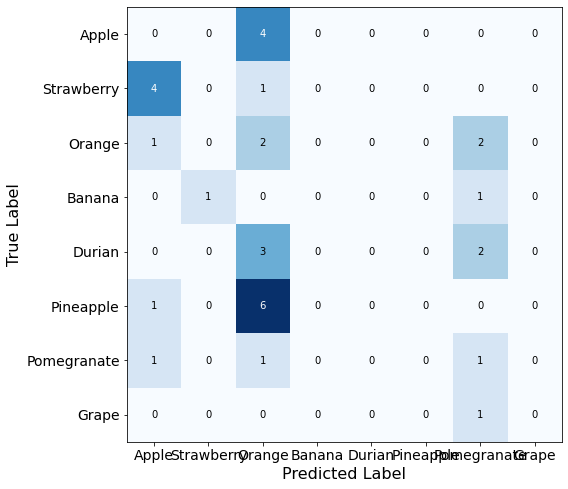

[0 0 4 0 0 0 0 0 4 0 1 0 0 0 0 0 1 0 2 0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 3 0 0
 0 2 0 1 0 6 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0]


ValueError: too many values to unpack (expected 4)

In [44]:
precisions = []
recalls = []
f1s = []
accuracies = []
with torch.no_grad():
    model.eval()
    for datas, labels in dataloaders['test']:
        datas, labels = datas.to(device), labels.to(device)
        outputs = model(datas)
        precision, recall, f1 = metrics(outputs, labels)
        acc = accuracy(outputs,labels)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(acc.item())

In [19]:
['{:.2f}%'.format(f * 100) for f in f1s]

['96.00%',
 '100.00%',
 '100.00%',
 '100.00%',
 '97.30%',
 '100.00%',
 '100.00%',
 '100.00%',
 '96.97%',
 '100.00%',
 '100.00%',
 '100.00%',
 '100.00%',
 '97.44%',
 '100.00%',
 '100.00%',
 '100.00%']